# Time Series Analysis on Pop Songs from Spotify

## Loading and cleaning the data

In [1]:
# First install seaborn and statsmodels in terminal
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot # check if I'm actually using this
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [2]:
# Open dataset as dataframe
df = pd.read_csv('spotify_pop_songs.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,id,title,first_artist,all_artists,danceability,energy,key,loudness,...,liveness,valence,tempo,duration_ms,time_signature,num_bars,num_sections,num_segments,genres_artist,release_date_album
0,0,0,0wz1LjDb9ZNEYwOmDJ3Q4b,Surfin' U.S.A. - Remastered 2001,The Beach Boys,['The Beach Boys'],0.550,0.854,3,-5.968,...,0.112,0.965,159.231,149373,4,96,8,614,"['baroque pop', 'classic rock', 'folk rock', '...",1963-03-25
1,1,1,7tqhbajSfrz2F7E1Z75ASX,Ain't No Mountain High Enough,Marvin Gaye,"['Marvin Gaye', 'Tammi Terrell']",0.663,0.600,7,-10.870,...,0.184,0.800,129.991,151667,4,79,8,491,"['classic soul', 'motown', 'neo soul', 'northe...",1967-08-29
2,2,2,0fonScmHUzC0MglSLn9saA,Da Doo Ron Ron (When He Walked Me Home),The Crystals,['The Crystals'],0.535,0.797,3,-7.533,...,0.141,0.613,148.835,140120,4,84,8,517,"['classic girl group', 'doo-wop', 'rock-and-ro...",2011-02-22
3,3,3,20OFwXhEXf12DzwXmaV7fj,Bad Moon Rising,Creedence Clearwater Revival,['Creedence Clearwater Revival'],0.508,0.774,2,-5.973,...,0.063,0.942,178.946,141600,4,98,9,515,"['classic rock', 'country rock', 'rock', 'sout...",1969-08-03
4,4,4,3VbGCXWRiouAq8VyMYN2MI,Love Me Do - Remastered 2009,The Beatles,['The Beatles'],0.520,0.829,0,-6.228,...,0.227,0.744,147.997,141693,4,84,5,485,"['beatlesque', 'british invasion', 'classic ro...",1963-03-22


In [3]:
# Dropping columns I don't need
df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)

In [4]:
df = df.loc[df["genres_artist"].str.contains("pop")] 
len(df) # Now there's 1430 songs left, so 833 songs have been filtered out. 

1430

In [5]:
# Extract only the years using string manipulation
df['release_year'] = df['release_date_album'].str.extract(r'(\d{4})')

# Drop the original date column
#df = df.drop('release_date_album', axis=1)

print(df)

                          id                              title   
0     0wz1LjDb9ZNEYwOmDJ3Q4b   Surfin' U.S.A. - Remastered 2001  \
5     11fNLqDB47gMKj7BHhR2Qr               Wake up Little Susie   
9     3G7tRC24Uh09Hmp1KZ7LQ2     I'm a Believer - 2006 Remaster   
19    5t9KYe0Fhd5cW6UYT4qP8f  Good Vibrations - Remastered 2001   
23    6MTd61g9zq6CB1FnJydjEb                        Sugar Sugar   
...                      ...                                ...   
2257  3RauEVgRgj1IuWdJ9fDs70                            The Man   
2259  6NFyWDv5CjfwuzoCkw47Xf                           Delicate   
2260  53tfEupEzQRtVFOeZvk7xq                           DESPECHÁ   
2261  2BgEsaKNfHUdlh97KmvFyo                               2002   
2262  45S5WTQEGOB1VHr1Q4FuPl                             Golden   

             first_artist              all_artists  danceability  energy  key   
0          The Beach Boys       ['The Beach Boys']         0.550   0.854    3  \
5     The Everly Brothers  ['The 

In [6]:
df['release_year'] = df['release_year'].astype(int) # reading release_year as integers instead of strings
df['release_year'].isna().sum() # Making sure that there are no empty release_year values

0

## Audio Features Correlation Analysis

Pandas' corr method and seaborn's heatmap are used to calculate the correlations between the different variables and visualize them. 

<Axes: >

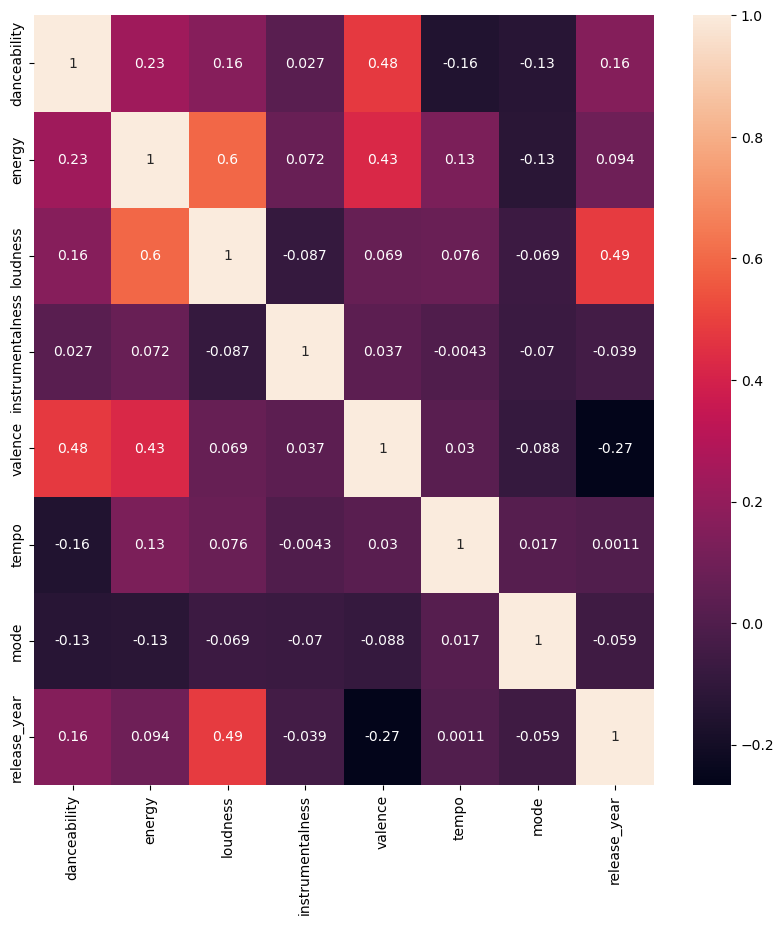

In [7]:
corr = df[["danceability", "energy", "loudness", "instrumentalness", "valence",
          "tempo", "mode", "release_year"]].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)

### Observations from heatmap

There is a fairly strong positive correlation between loudness and energy (0.6), which is what we would expect, since Spotify states that perceived loudness is a feature that attributes to the energy score of a song.

There seem to be mild positive correlations between valence and danceability (0.48) and valence and energy (0.43). These correlations cannot directly be explained by Spotify's own descriptions of the musical elements contributing to the features, but indirectly they make sense. Namely, valence describes the musical positiveness described by a song, which should be relevant to how energetic and eager to dance that song makes the listener feel.

Strikingly, there is a notable positive correlation between release_year and loudness (0.49), which will be further investigated in this analysis.

## Track Count Per Year

The number of songs is plotted for each year to see whether the data is equally distributed over all the 64 years.

Text(0.5, 0, 'Year')

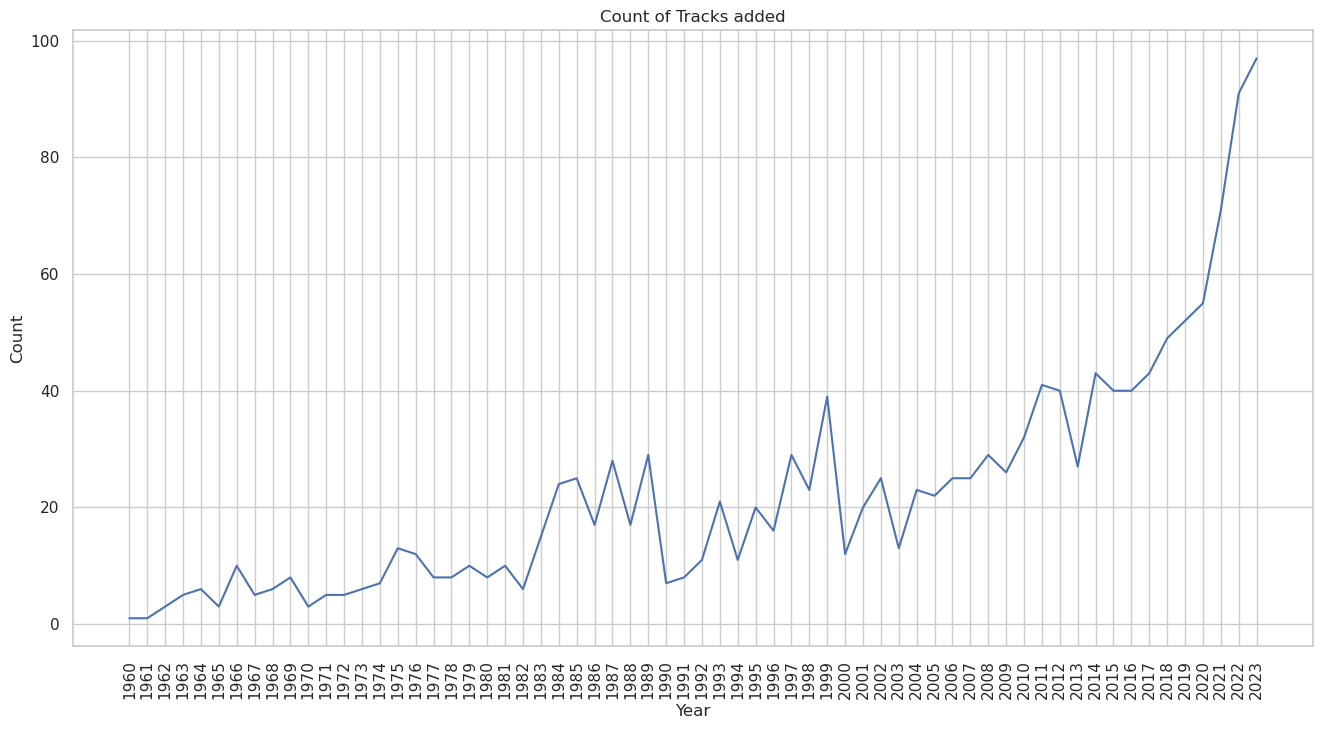

In [8]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
df_sorted = df.sort_values("release_year")  # Sort the DataFrame by release_year
x = df_sorted.groupby("release_year")["id"].count()
ax = sns.lineplot(x=x.index, y=x)
ax.set_title('Count of Tracks added')
ax.set_xticks(x.index)  # Set the x-axis ticks to the sorted index values
ax.set_xticklabels(x.index, rotation='vertical')  # Set the x-axis tick labels
ax.set_ylabel('Count')
ax.set_xlabel('Year')


The above plot shows that the dataset contains many more songs for recent years than for earlier years. Especially many songs in the dataset have been released since 2020. This can be explained by the fact that the dataset contains playlists generated by Spotify within the genre pop, and Spotify updates those playlists on a regular basis. The pop playlists that do not belong to a specific era might therefore consists of more 'new' songs than songs from many years ago. 

This is something that should be taken into account when interpreting and generalizing results.

## Linear regression

### Descriptive statistics

In [18]:
subset = df[["danceability", "tempo", "mode", "energy", "instrumentalness", "valence", "loudness", 
             "release_year"]]
subset.describe()

,danceability,tempo,mode,energy,instrumentalness,valence,loudness,release_year
count,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000
mean,0.637397,119.739887,0.641958,0.665941,0.013445,0.575306,-6.985671,2004.929371
std,0.136691,24.729215,0.479592,0.182554,0.078957,0.242834,2.948233,15.915317
min,0.180000,61.859000,0.000000,0.127000,0.000000,0.038200,-17.707000,1960.000000
25%,0.557000,102.147250,0.000000,0.548000,0.000000,0.383000,-8.485000,1994.000000
50%,0.654000,119.977000,1.000000,0.695000,0.000002,0.587000,-6.174500,2010.000000
75%,0.734000,130.544500,1.000000,0.805000,0.000115,0.779000,-4.859000,2019.000000
max,0.967000,208.571000,1.000000,0.997000,0.850000,0.984000,-1.248000,2023.000000


In [19]:
import statsmodels.api as sm

# Separate the independent variable (release_year) from the dependent variables
X = df['release_year']
y_danceability = df['danceability']
y_tempo = df['tempo']
y_mode = df['mode']
y_energy = df['energy']
y_instrumentalness = df['instrumentalness']
y_valence = df['valence']
y_loudness = df['loudness']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Create separate linear regression models for each dependent variable
model_danceability = sm.OLS(y_danceability, X).fit()
model_tempo = sm.OLS(y_tempo, X).fit()
model_mode = sm.OLS(y_mode, X).fit()
model_energy = sm.OLS(y_energy, X).fit()
model_instrumentalness = sm.OLS(y_instrumentalness, X).fit()
model_valence = sm.OLS(y_valence, X).fit()
model_loudness = sm.OLS(y_loudness, X).fit()

# Print the summaries of the linear regression models
print("Danceability model:")
print(model_danceability.summary())
print("\nTempo model:")
print(model_tempo.summary())
print("\nMode model:")
print(model_mode.summary())
print("\nEnergy model:")
print(model_energy.summary())
print("\nInstrumentalness model:")
print(model_instrumentalness.summary())
print("\nValence model:")
print(model_valence.summary())
print("\nLoudness model:")
print(model_loudness.summary())


Danceability model:
                            OLS Regression Results                            
Dep. Variable:           danceability   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     36.00
Date:                Wed, 31 May 2023   Prob (F-statistic):           2.50e-09
Time:                        14:57:30   Log-Likelihood:                 834.96
No. Observations:                1430   AIC:                            -1666.
Df Residuals:                    1428   BIC:                            -1655.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0627     

## Time Series Visualization

To get an insight into how the features of pop songs have changed over the period 1960-2023, the average yearly values are obtained first. Then, I visualize the data by creating line graphs for each variable over time.

In [20]:
year_avg = df[["danceability","energy", "loudness", "instrumentalness", "valence", "tempo", "mode", "release_year"]].\
groupby("release_year").mean().sort_values(by="release_year").reset_index()

year_avg.head() # This dataframe contains the average values for the different features for each year.

,release_year,danceability,energy,loudness,instrumentalness,valence,tempo,mode
0,1960,0.743000,0.799000,-5.466000,0.000000,0.9650,116.112000,0.000000
1,1961,0.746000,0.408000,-12.661000,0.000000,0.8370,117.940000,0.000000
2,1962,0.453333,0.423000,-10.020333,0.000000,0.5840,94.227333,1.000000
3,1963,0.609800,0.617800,-8.955000,0.000043,0.8548,123.753400,1.000000
4,1964,0.572333,0.582333,-8.725167,0.001149,0.7515,120.009333,0.833333


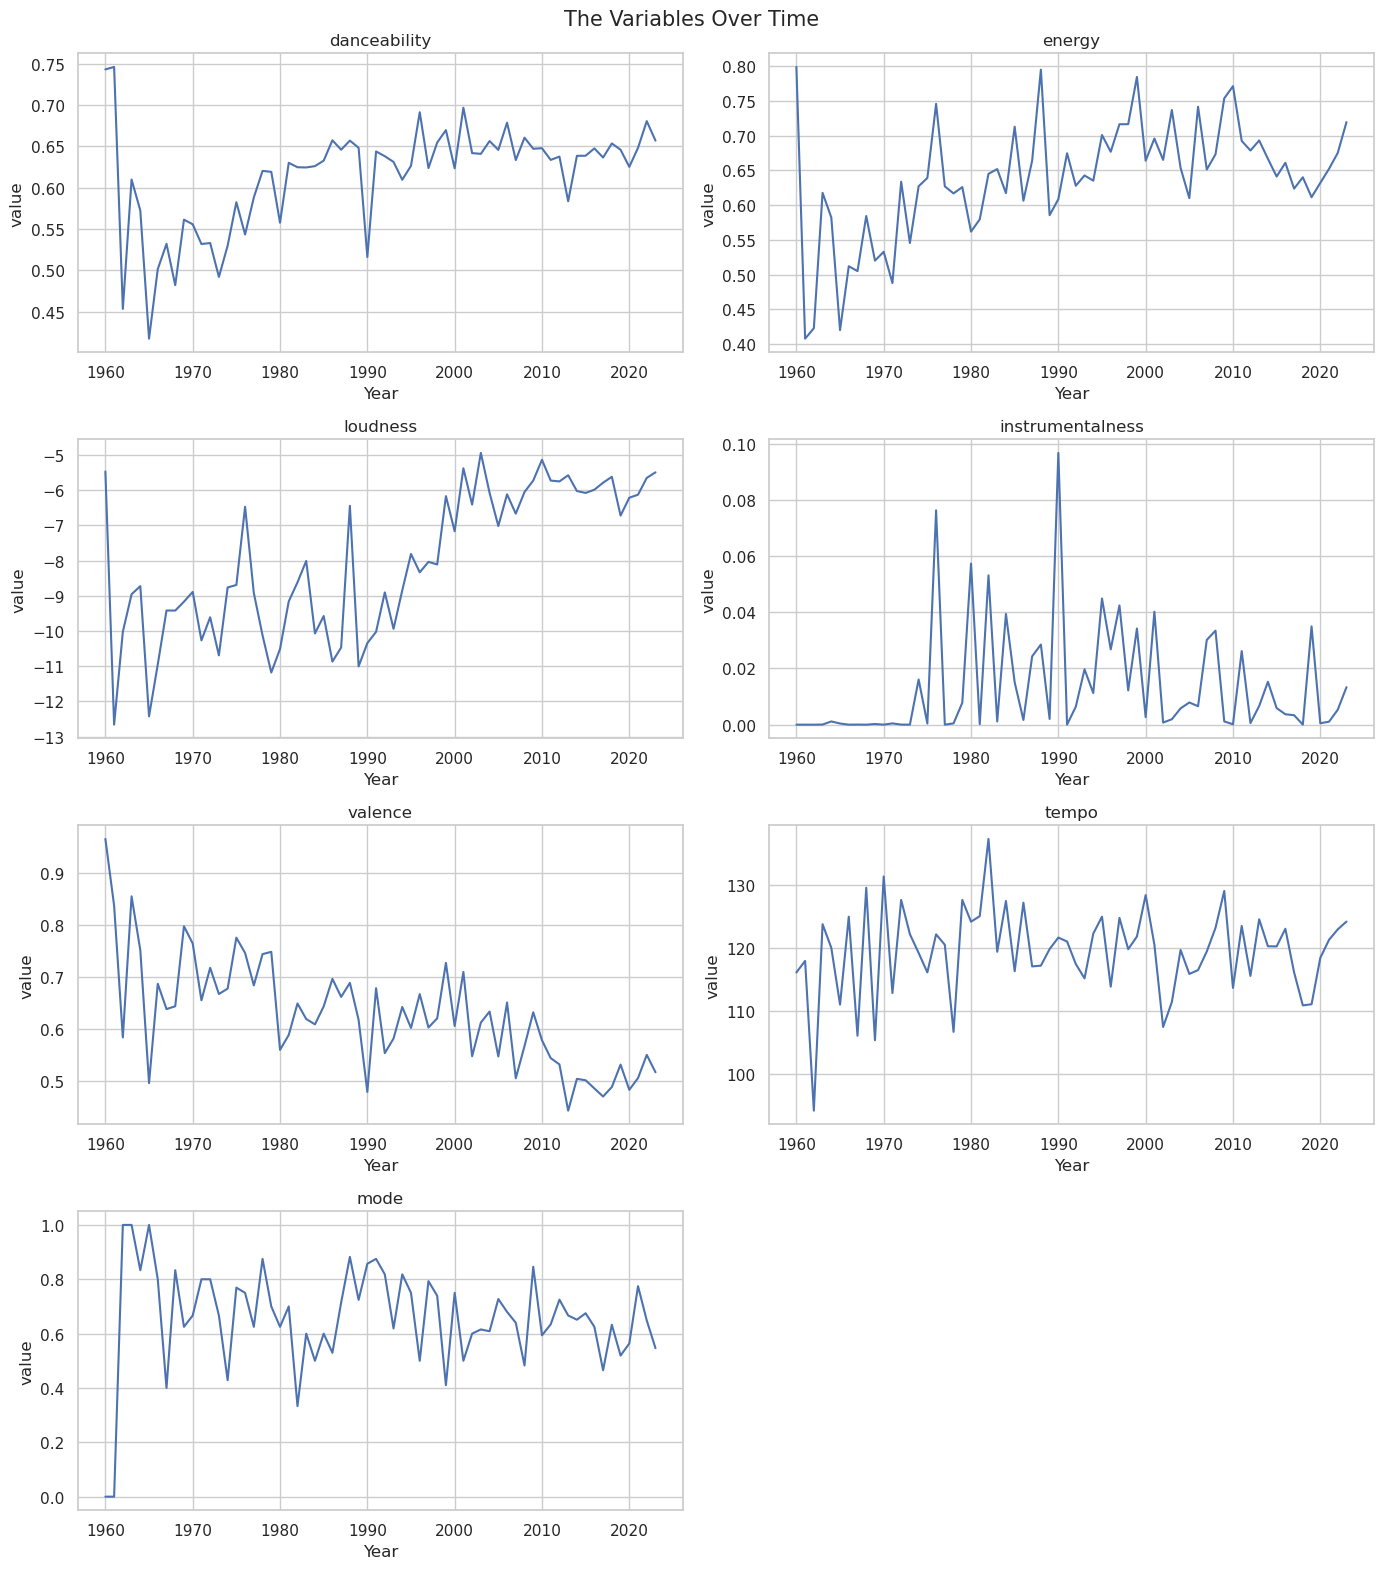

In [21]:
# Define the variables to plot
variables = ["danceability","energy", "loudness", "instrumentalness", "valence", "tempo", "mode"] # if doesn't work, delete loudness

# Create the main figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
fig.suptitle("The Variables Over Time", fontsize=15)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each variable in a separate subplot
for i, variable in enumerate(variables):
    ax = axes[i]
    ax.set_ylabel("value")
    ax.set_xlabel("Year")
    ax.set_title(variable)
    
    sns.lineplot(x='release_year', y=variable, data=year_avg, ax=ax)

# Remove any empty subplots if the number of variables is less than the number of subplots
if len(variables) < len(axes):
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In general, the variables all fluctuate a lot over the course of 64 years. Valence and Mode might follow a negative trend, while Danceability, Energy and Loudness might follow a positive trend. At first sight, Instrumentalness and Tempo do not seem to show a trend. [ADD MORE?]

## Times Series Decomposition

To identify any long-term patterns, a trend analysis is conducted on each variable. First, I plot the autocorrelation functions to look into seasonality and repeating patterns in the data. Then, I perform simple linear regression to assess the presence and significance of trends.

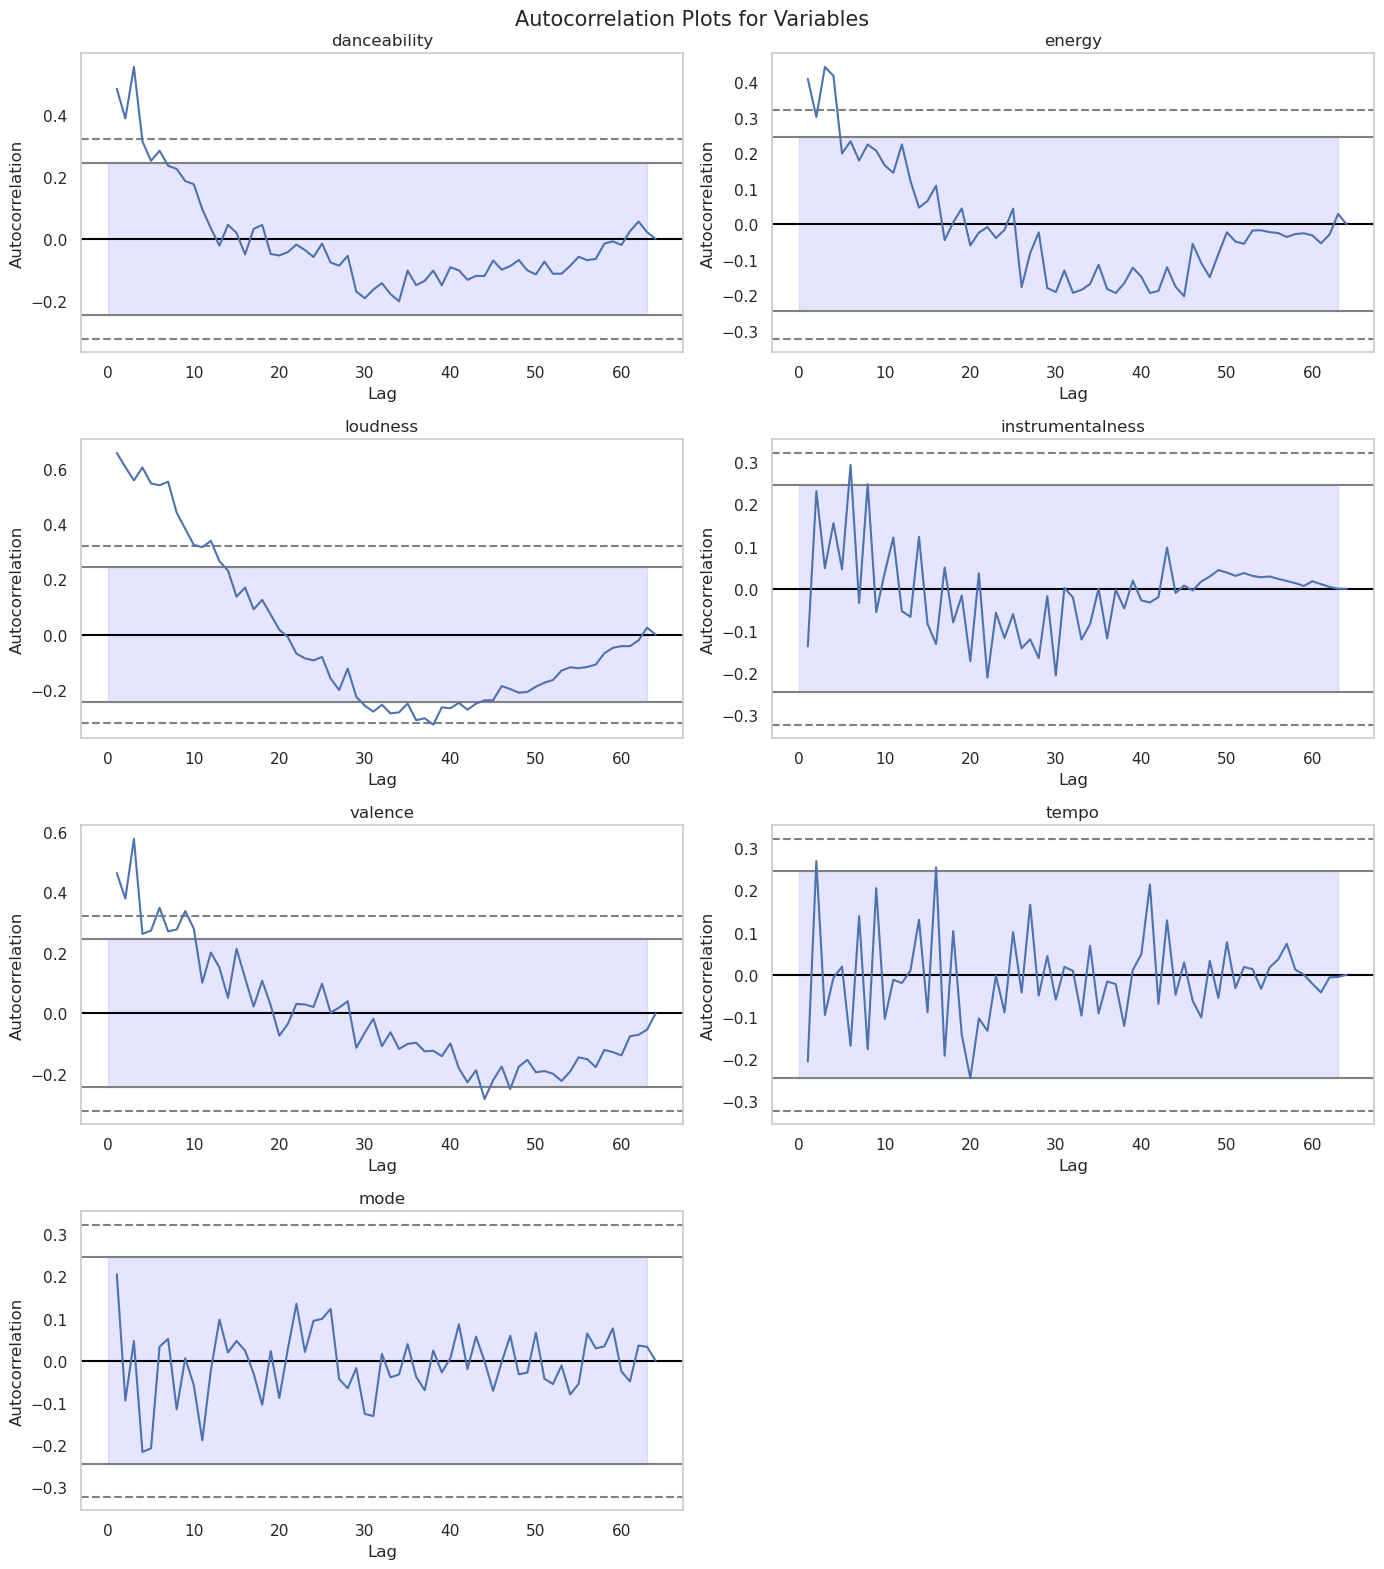

In [22]:
# Create the main figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
fig.suptitle("Autocorrelation Plots for Variables", fontsize=15)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot autocorrelation for each variable in a separate subplot
for i, variable in enumerate(variables):
    ax = axes[i]
    ax.set_xlabel("Lag (in years)")
    ax.set_ylabel("Autocorrelation")
    ax.set_title(variable)
    
    autocorrelation_plot(year_avg[variable], ax=ax)
    
    # Add shaded blue color for confidence intervals
    ax.fill_between(range(len(year_avg[variable])), -1.96/np.sqrt(len(year_avg[variable])), 
                    1.96/np.sqrt(len(year_avg[variable])), color='blue', alpha=0.1)

# Remove any empty subplots if the number of variables is less than the number of subplots
if len(variables) < len(axes):
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Interpreting the autocorrelation function plots

The autocorrelation function plots show the correlation between a variable's values at different time lags. In these plots, the lags represent the release years of songs. The y-axis represents the autocorrelation coefficient, which values are statistically significant outside of the 95% confidence interval (the shaded blue region). Positive and significant values for the autocorrelation coefficient suggest a positive correlation between values in those years, and vice versa for negative values. 

For Danceability, Energy, Tempo and Mode the plots indicate randomness or white noise in the data. Loudness, Instrumentalness and Valence will be further investigated. 


## Decomposition of the time series

#### Decomposition for loudness

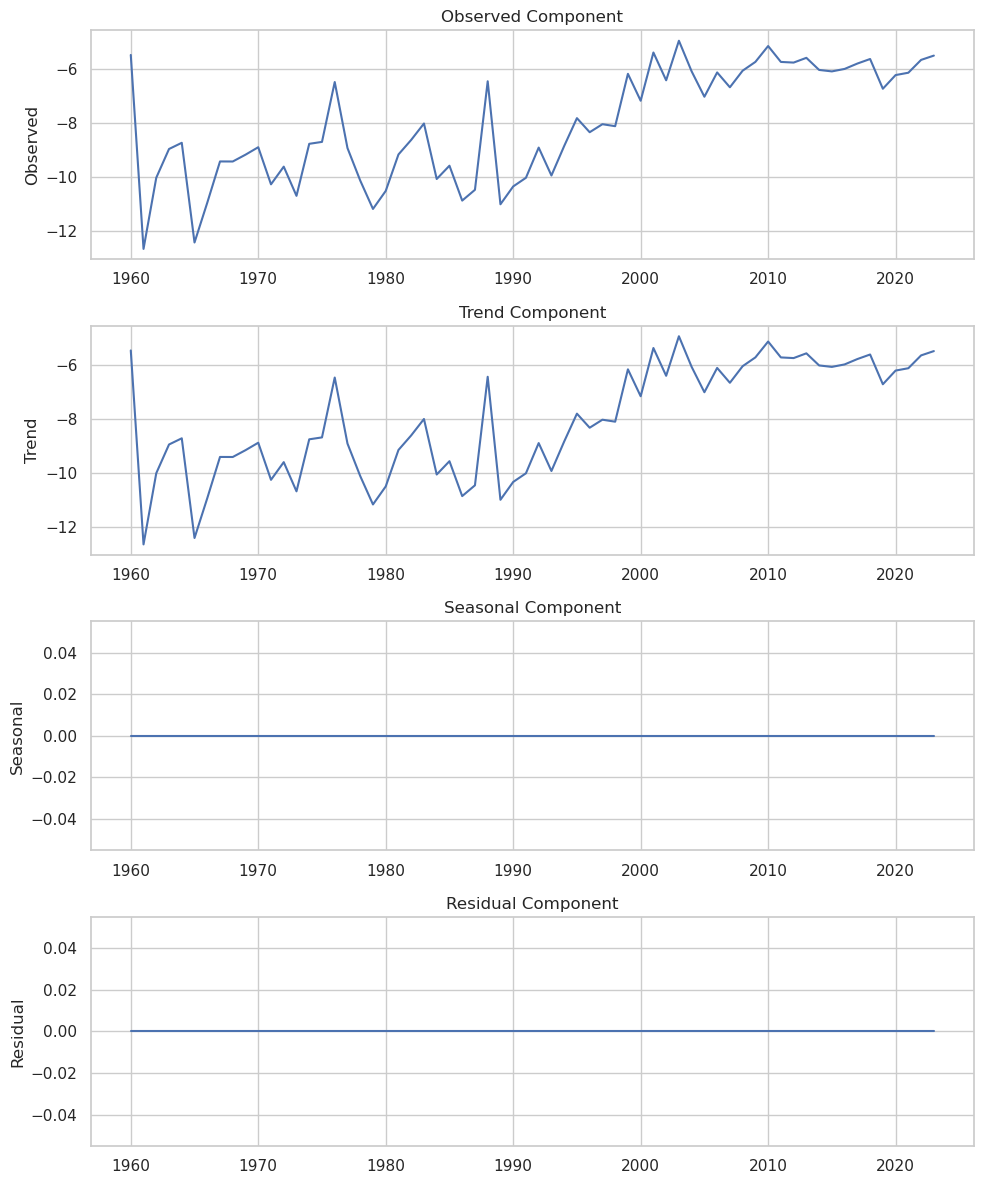

In [30]:
# Convert dataset to time series
ts = pd.Series(year_avg["loudness"].values, index=year_avg["release_year"])

# Perform STL decomposition
decomposition = seasonal_decompose(ts, model='additive', period=1)

# Get the trend component
trend = decomposition.trend

# Get the seasonal component
seasonal = decomposition.seasonal

# Get the residual component
residual = decomposition.resid

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))

# Plot the observed component
axes[0].plot(ts.index, ts.values)
axes[0].set_ylabel("Observed")
axes[0].set_title("Observed Component")

# Plot the trend component
axes[1].plot(trend.index, trend.values)
axes[1].set_ylabel("Trend")
axes[1].set_title("Trend Component")

# Plot the seasonal component
axes[2].plot(seasonal.index, seasonal.values)
axes[2].set_ylabel("Seasonal")
axes[2].set_title("Seasonal Component")

# Plot the residual component
axes[3].plot(residual.index, residual.values)
axes[3].set_ylabel("Residual")
axes[3].set_title("Residual Component")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


#### Decomposition of instrumentalness

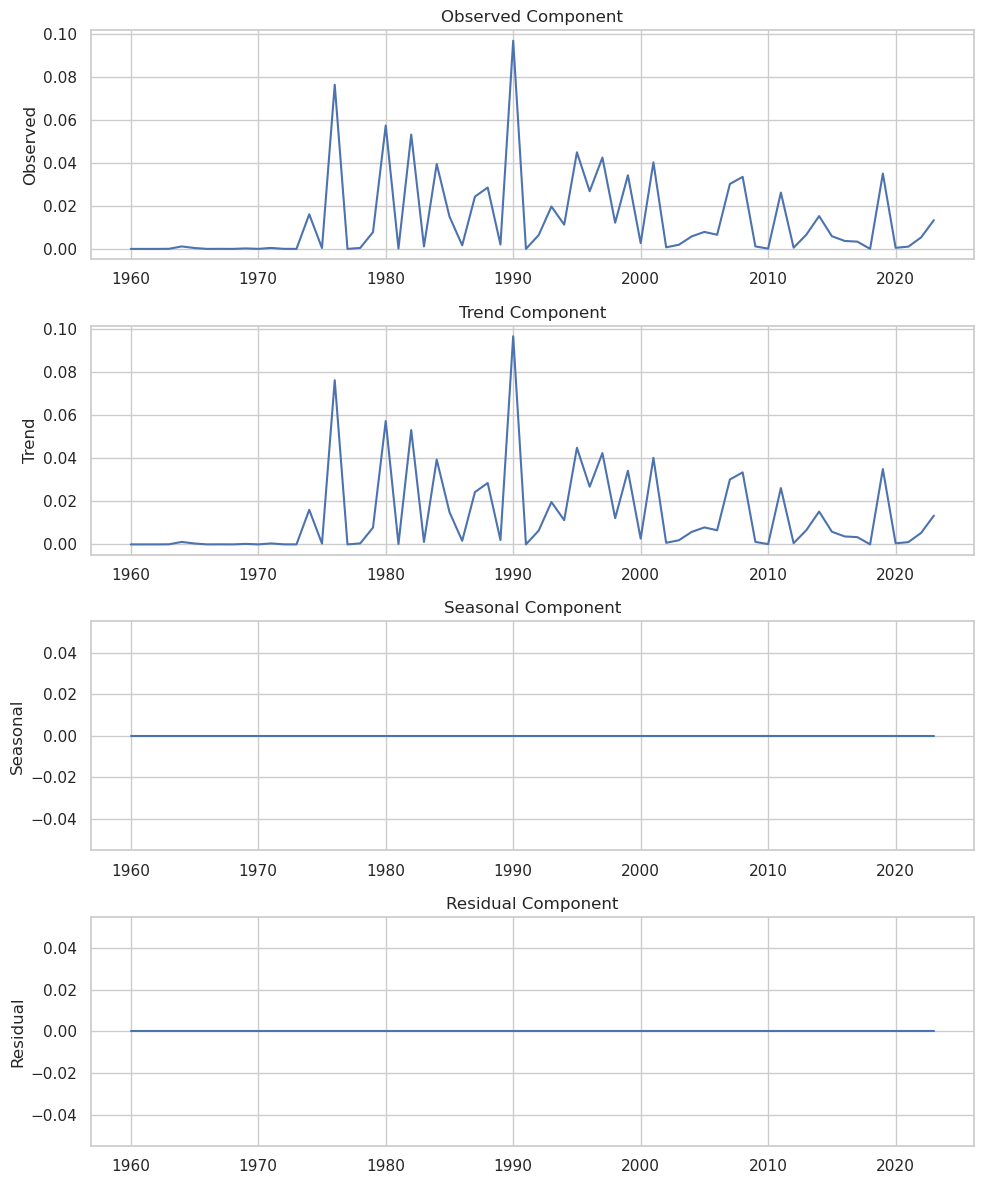

In [25]:
# Convert dataset to time series
ts = pd.Series(year_avg["instrumentalness"].values, index=year_avg["release_year"])

# Perform STL decomposition
decomposition = seasonal_decompose(ts, model='additive', period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))

# Plot the observed component
axes[0].plot(ts.index, ts.values)
axes[0].set_ylabel("Observed")
axes[0].set_title("Observed Component")

# Plot the trend component
axes[1].plot(trend.index, trend.values)
axes[1].set_ylabel("Trend")
axes[1].set_title("Trend Component")

# Plot the seasonal component
axes[2].plot(seasonal.index, seasonal.values)
axes[2].set_ylabel("Seasonal")
axes[2].set_title("Seasonal Component")

# Plot the residual component
axes[3].plot(residual.index, residual.values)
axes[3].set_ylabel("Residual")
axes[3].set_title("Residual Component")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


#### Decomposition of valence

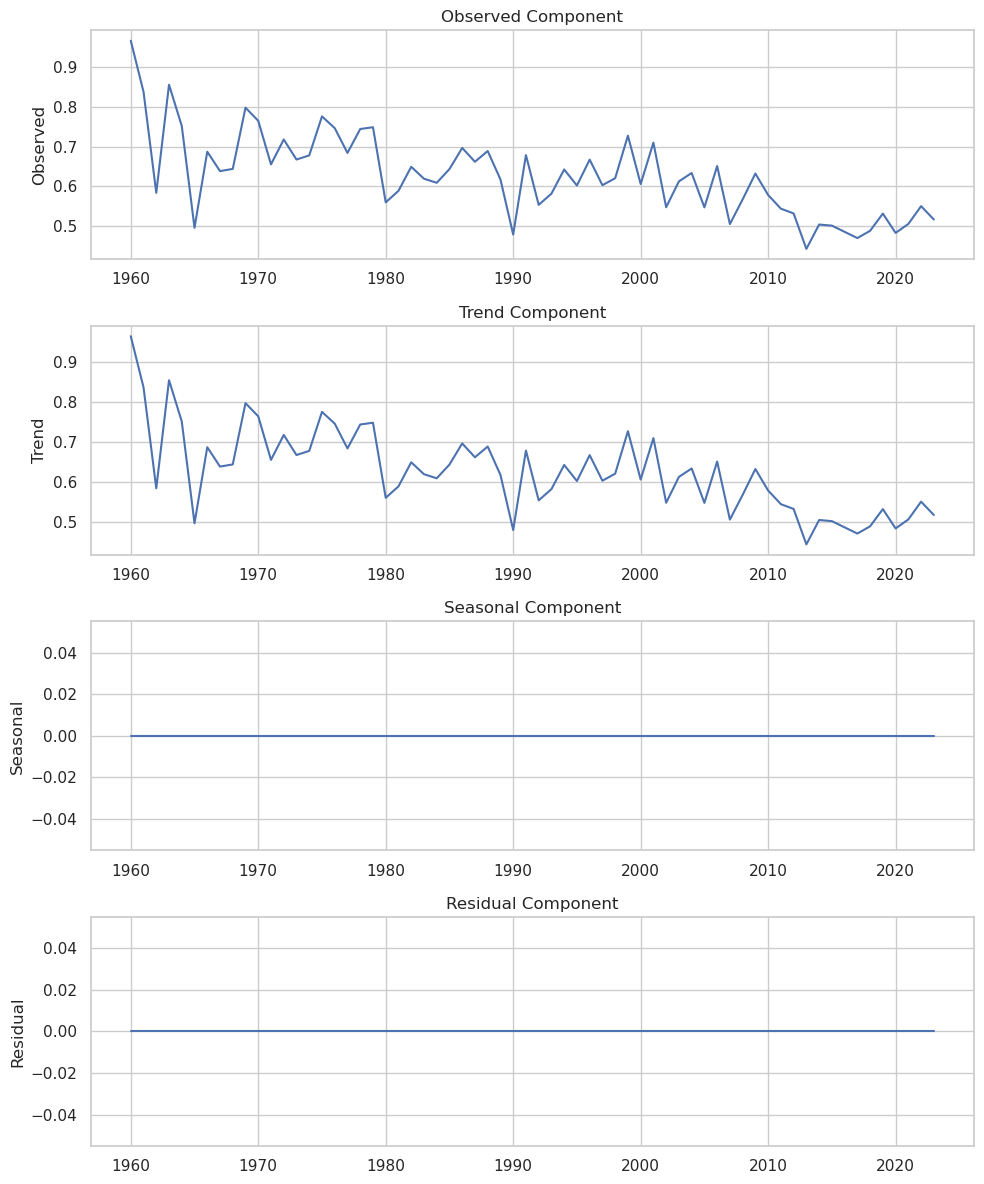

In [29]:
# Convert valence data points to time series
ts = pd.Series(year_avg["valence"].values, index=year_avg["release_year"])

# Perform STL decomposition
decomposition = seasonal_decompose(ts, model='additive', period=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12))

# Plot the observed component
axes[0].plot(ts.index, ts.values)
axes[0].set_ylabel("Observed")
axes[0].set_title("Observed Component")

# Plot the trend component
axes[1].plot(trend.index, trend.values)
axes[1].set_ylabel("Trend")
axes[1].set_title("Trend Component")

# Plot the seasonal component
axes[2].plot(seasonal.index, seasonal.values)
axes[2].set_ylabel("Seasonal")
axes[2].set_title("Seasonal Component")

# Plot the residual component
axes[3].plot(residual.index, residual.values)
axes[3].set_ylabel("Residual")
axes[3].set_title("Residual Component")

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()
